In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPool2D,Reshape,Activation,BatchNormalization,Dropout,Permute
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


In [4]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [5]:
c1 = Counter(y_train_valid)
d1 = Counter(person_train_valid[:,0])
print(c1)
print(d1)
c2 = Counter(y_test)
d2 = Counter(person_test[:,0])
print(c2)
print(d2)

Counter({771: 543, 772: 530, 769: 529, 770: 513})
Counter({6.0: 238, 0.0: 237, 1.0: 236, 2.0: 236, 5.0: 236, 4.0: 235, 3.0: 234, 7.0: 232, 8.0: 231})
Counter({770: 127, 769: 111, 772: 109, 771: 96})
Counter({0.0: 50, 1.0: 50, 2.0: 50, 3.0: 50, 6.0: 50, 7.0: 50, 5.0: 49, 4.0: 47, 8.0: 47})


In [6]:
Subject=np.array([0,1,2,3,4,5,6,7,8])
Class =np.array([769,770,771,772])
data=np.zeros([4,9])
for i in range(4):
    for j in range(9):
        loc=np.argwhere(person_train_valid==Subject[j])[:,0]
        data[i,j]=sum(y_train_valid[loc]==Class[i])

idx_name=['left','right','foot','tongue']
column_name=['Subject_0', 'Subject_1','Subject_2','Subject_3','Subject_4','Subject_5','Subject_6','Subject_7','Subject_8']
df = pd.DataFrame(data=data,index=idx_name, columns=column_name)
df.astype(np.int64)

,Subject_0,Subject_1,Subject_2,Subject_3,Subject_4,Subject_5,Subject_6,Subject_7,Subject_8
left,60,60,56,66,55,57,59,60,56
right,59,57,60,54,60,55,54,56,58
foot,58,62,63,56,59,62,64,60,59
tongue,60,57,57,58,61,62,61,56,58


In [7]:
# Splitting data by subject 
person_train_valid = person_train_valid.astype(int)
person_test = person_test.astype(int)

ids = range(0, 9) # IDs 0-8 inclusive

train_valid_subject_idx = defaultdict(list) # key: id 0-8, value: list of indices of training data for that id 
test_subject_idx = defaultdict(list)

num_trials, num_channels, num_bins = X_train_valid.shape
num_test = X_test.shape[0]

for i in range(num_trials):
    train_valid_subject_idx[person_train_valid[i][0]].append(i)
    
for i in range(num_test):
    test_subject_idx[person_test[i][0]].append(i)
# Sanity check to see if partitioning by subject ID worked

print(len(train_valid_subject_idx[0]))
print(len(test_subject_idx[0]))   
# change the label in one-hot encoding
y_train_valid-=769
y_test-=769
y_train_valid_onehot = to_categorical(y_train_valid)
y_test_onehot= to_categorical(y_test)

237
50


In [8]:
# Split the training data and Validation data
# Remove the 1st decond which is the cue period
EEG_22=False
is_3s=True
n_sub = 2
split_size=0.2
#True:{1,2,3,5,10,15} False:{1,2,4,5,8,10,20}
if EEG_22==True:
    EEG_train_valid = X_train_valid[:,:22,:].reshape(-1,22,1000,1)
    EEG_test  = X_test[:,:22,:].reshape(-1,22,1000,1)
else:
    EEG_train_valid = X_train_valid[:,:25,:].reshape(-1,25,1000,1)
    EEG_test  = X_test[:,:25,:].reshape(-1,25,1000,1)

print ('Training/Valid data shape: {}'.format(EEG_train_valid.shape))
print ('Test data shape: {}'.format(EEG_test.shape))

n_train=int(2115*(1-split_size))
n_valid=int(2115*split_size)
n_test=443

EEG_train, EEG_valid, y_train, y_valid = train_test_split(
    EEG_train_valid, y_train_valid_onehot, test_size=split_size, shuffle=True)

print ('Original Training data shape: {}'.format(EEG_train.shape))
print ('Original Validation data shape: {}'.format(EEG_valid.shape))
print ('Original Testing data shape: {}'.format(EEG_test.shape))
EEG_3s_train=EEG_train[:,:,250:1000,:]
EEG_3s_valid=EEG_valid[:,:,250:1000,:]
EEG_3s_test=EEG_test[:,:,250:1000,:]
print ('3Second Training data shape: {}'.format(EEG_3s_train.shape))
print ('3Second Validation data shape: {}'.format(EEG_3s_valid.shape))
print ('3Second Testing data shape: {}'.format(EEG_3s_test.shape))

Training/Valid data shape: (2115, 25, 1000, 1)
Test data shape: (443, 25, 1000, 1)
Original Training data shape: (1692, 25, 1000, 1)
Original Validation data shape: (423, 25, 1000, 1)
Original Testing data shape: (443, 25, 1000, 1)
3Second Training data shape: (1692, 25, 750, 1)
3Second Validation data shape: (423, 25, 750, 1)
3Second Testing data shape: (443, 25, 750, 1)


### Down sample the original data

In [9]:
if is_3s==True:
    print("use the 3-seconds data:")
    new_train=np.zeros([n_train*n_sub,EEG_train.shape[1],750//n_sub,1],dtype='float64')
    new_valid=np.zeros([n_valid*n_sub,EEG_train.shape[1],750//n_sub,1],dtype='float64')
    new_test=np.zeros([n_test*n_sub,EEG_train.shape[1],750//n_sub,1],dtype='float64')    
else:
    print("use the 4-seconds data:")
    new_train=np.zeros([n_train*n_sub,EEG_train.shape[1],1000//n_sub,1],dtype='float64')
    new_valid=np.zeros([n_valid*n_sub,EEG_train.shape[1],1000//n_sub,1],dtype='float64')
    new_test=np.zeros([n_test*n_sub,EEG_train.shape[1],1000//n_sub,1],dtype='float64')
yy_train= np.zeros([new_train.shape[0],4],dtype='float64')
yy_valid= np.zeros([new_valid.shape[0],4],dtype='float64')
yy_test_onehot= np.zeros([new_test.shape[0],4],dtype='float64')
for i in range(n_sub)  :
    if is_3s==True:
        new_train[i*n_train:(i+1)*n_train]=EEG_3s_train[:,:,i:750:n_sub,:]
        new_valid[i*n_valid:(i+1)*n_valid]=EEG_3s_valid[:,:,i:750:n_sub,:]
        new_test[i*n_test:(i+1)*n_test]=EEG_3s_test[:,:,i:750:n_sub,:]
    else:
        new_train[i*n_train:(i+1)*n_train]=EEG_train[:,:,i:1000:n_sub,:]
        new_valid[i*n_valid:(i+1)*n_valid]=EEG_valid[:,:,i:1000:n_sub,:]
        new_test[i*n_test:(i+1)*n_test]=EEG_test[:,:,i:1000:n_sub,:]
    yy_train[i*n_train:(i+1)*n_train]= y_train
    yy_valid[i*n_valid:(i+1)*n_valid]=y_valid
    yy_test_onehot[i*n_test:(i+1)*n_test]=y_test_onehot
print ('New Training data shape: {}'.format(new_train.shape))
print ('New Validation data shape: {}'.format(new_valid.shape))
print ('New Testing data shape: {}'.format(new_test.shape))

use the 3-seconds data:
New Training data shape: (3384, 25, 375, 1)
New Validation data shape: (846, 25, 375, 1)
New Testing data shape: (886, 25, 375, 1)


### CNN Deep ConvNet Architecture (with down sample Data)
Input Dimension: 25x375x1
0. `Projected FC Block`
<br>Fully connected layer
<br>  $\longrightarrow$ 30x375x1
1. `Conv-Pool Block`
<br>Convolutional layer with 60 1x15 kernels, with stride 1,3, valid padding
<br>  $\longrightarrow$ 30x121x60
<br>ELU 
<br>Max Pooling Stride 1x2 with same padding 
<br>  $\longrightarrow$ 30x61x60
2. `Conv-Pool Block`
<br>Convolutional layer with 60 1x4 kernels, with stride 1,2,valid padding
<br>  $\longrightarrow$ 30x29x60
<br>ELU
<br>Max Pooling Stride 1x2 with same padding 
<br>  $\longrightarrow$ 30x15x60
3. `Conv-Pool Block`
<br>Convolutional layer with 60 30x1 kernels, with stride 1,1,valid padding
<br>  $\longrightarrow$ 1x15x60
<br>ELU
<br>Convolutional layer with 90 1x3 kernels, with stride 1,1,same padding
<br>  $\longrightarrow$ 1x15x90
<br>ELU
<br>Max Pooling Stride 1x2, with same padding 
<br>  $\longrightarrow$ 1x8x90

4. `Conv-Pool Block`
<br>Convolutional layer with 120 1x3 kernels, with stride 1,1,same padding
<br>  $\longrightarrow$ 1x8x120
<br>ELU
<br>Max Pooling Stride 1x2, same padding
<br>  $\longrightarrow$ 1x4x120
5. `FC Layer`
<br> Flatten
<br>  $\longrightarrow$ 480
<br> Dense Layer 
<br>  $\longrightarrow$ 95
6. `Classification Layer`
<br> Dense Layer 
<br>  $\longrightarrow$ 4
<br> Softmax

In [11]:
model = Sequential()
#model.add(Flatten(input_shape=(22,375,1)))
#model.add(Dense(11250,kernel_regularizer=regularizers.l2(0.01)))
#model.add(Reshape((30, 375,1)))
#model.add(Activation('elu'))
VarianceScaling=keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None)
model.add(Permute(( 3,2,1),input_shape=(25,375,1)))
#model.add(Dense(40,kernel_initializer=VarianceScaling,bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(30,kernel_regularizer=regularizers.l2(0.01)))
model.add(Permute((3,2,1)))
#model.add(Activation('elu'))
#model.add(Dropout(0.5))

model.add(Conv2D(60, kernel_size=(1,15), strides=(1,3),padding='valid',kernel_regularizer=regularizers.l2(0.01),input_shape=(22,375,1)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPool2D(pool_size=(1,2),strides=(1,2),padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(60, kernel_size=(1,4), strides=(1,2),padding='valid',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPool2D(pool_size=(1,2),strides=(1,2),padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(60, kernel_size=(30,1), strides=(1,1),padding='valid',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Conv2D(90, kernel_size=(1,3), strides=(1,1),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPool2D(pool_size=(1,2),strides=(1,2),padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(120, kernel_size=(1,3), strides=(1,1),padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPool2D(pool_size=(1,2),strides=(1,2),padding='same'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(95,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))
print(model.summary())

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adam= optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop= optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#model.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
#model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
with tf.Session( config = tf.ConfigProto( log_device_placement = True ) ):
    #model.fit(new_train,yy_train,validation_data=(new_valid,yy_valid),epochs=500,batch_size=60,shuffle=True,callbacks=[early_stopping])
    history=model.fit(new_train,yy_train,validation_data=(new_valid,yy_valid),epochs=500,batch_size=60,shuffle=True)
    model.evaluate(x=new_test, y=yy_test_onehot)
    score=model.predict(x=new_test)    

Train on 3384 samples, validate on 846 samples
Epoch 1/500
3384/3384 [==============================] - 30s 9ms/step - loss: 7.3610 - acc: 0.2485 - val_loss: 6.1348 - val_acc: 0.2801
Epoch 2/500
3384/3384 [==============================] - 1s 419us/step - loss: 6.6357 - acc: 0.2680 - val_loss: 6.0212 - val_acc: 0.3357
Epoch 3/500
3384/3384 [==============================] - 1s 418us/step - loss: 6.3792 - acc: 0.2352 - val_loss: 5.9126 - val_acc: 0.3262
Epoch 4/500
3384/3384 [==============================] - 1s 418us/step - loss: 6.1226 - acc: 0.2651 - val_loss: 5.8255 - val_acc: 0.2872
Epoch 5/500
3384/3384 [==============================] - 1s 417us/step - loss: 5.9554 - acc: 0.2733 - val_loss: 5.7212 - val_acc: 0.3050
Epoch 6/500
3384/3384 [==============================] - 1s 417us/step - loss: 5.7966 - acc: 0.2745 - val_loss: 5.6133 - val_acc: 0.3097
Epoch 7/500
3384/3384 [==============================] - 1s 418us/step - loss: 5.6817 - acc: 0.2701 - val_loss: 5.5124 - val_acc: 0.

3384/3384 [==============================] - 1s 417us/step - loss: 1.0075 - acc: 0.7683 - val_loss: 1.2964 - val_acc: 0.6690
Epoch 120/500
3384/3384 [==============================] - 1s 417us/step - loss: 1.0325 - acc: 0.7645 - val_loss: 1.2600 - val_acc: 0.6584
Epoch 121/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.9980 - acc: 0.7704 - val_loss: 1.3290 - val_acc: 0.6324
Epoch 122/500
3384/3384 [==============================] - 1s 417us/step - loss: 1.0002 - acc: 0.7710 - val_loss: 1.2430 - val_acc: 0.6525
Epoch 123/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.9785 - acc: 0.7772 - val_loss: 1.2858 - val_acc: 0.6548
Epoch 124/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.9674 - acc: 0.7754 - val_loss: 1.2419 - val_acc: 0.6785
Epoch 125/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.9446 - acc: 0.7807 - val_loss: 1.1669 - val_acc: 0.6879
Epoch 126/500
3384/3384 [================

3384/3384 [==============================] - 1s 417us/step - loss: 0.6842 - acc: 0.8336 - val_loss: 1.0352 - val_acc: 0.7009
Epoch 179/500
3384/3384 [==============================] - 1s 416us/step - loss: 0.6911 - acc: 0.8265 - val_loss: 1.0733 - val_acc: 0.6903
Epoch 180/500
3384/3384 [==============================] - 1s 419us/step - loss: 0.6785 - acc: 0.8351 - val_loss: 1.0010 - val_acc: 0.7187
Epoch 181/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.6847 - acc: 0.8289 - val_loss: 1.1722 - val_acc: 0.6738
Epoch 182/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.6796 - acc: 0.8339 - val_loss: 1.2716 - val_acc: 0.6418
Epoch 183/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.7213 - acc: 0.8197 - val_loss: 1.1048 - val_acc: 0.6738
Epoch 184/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.7043 - acc: 0.8274 - val_loss: 1.2026 - val_acc: 0.6525
Epoch 185/500
3384/3384 [================

3384/3384 [==============================] - 1s 418us/step - loss: 0.6255 - acc: 0.8511 - val_loss: 1.1069 - val_acc: 0.6903
Epoch 238/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.6147 - acc: 0.8579 - val_loss: 1.3036 - val_acc: 0.6525
Epoch 239/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.6307 - acc: 0.8466 - val_loss: 1.0888 - val_acc: 0.7104
Epoch 240/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.6091 - acc: 0.8582 - val_loss: 1.1863 - val_acc: 0.6915
Epoch 241/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.6226 - acc: 0.8490 - val_loss: 1.1961 - val_acc: 0.6773
Epoch 242/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.6089 - acc: 0.8558 - val_loss: 1.0853 - val_acc: 0.7187
Epoch 243/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.6163 - acc: 0.8520 - val_loss: 1.2765 - val_acc: 0.6738
Epoch 244/500
3384/3384 [================

3384/3384 [==============================] - 1s 417us/step - loss: 0.5897 - acc: 0.8712 - val_loss: 1.0838 - val_acc: 0.7116
Epoch 297/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.5784 - acc: 0.8735 - val_loss: 1.1717 - val_acc: 0.6809
Epoch 298/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5889 - acc: 0.8697 - val_loss: 1.1104 - val_acc: 0.7021
Epoch 299/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.6046 - acc: 0.8703 - val_loss: 1.0654 - val_acc: 0.6962
Epoch 300/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.6343 - acc: 0.8576 - val_loss: 1.0632 - val_acc: 0.7080
Epoch 301/500
3384/3384 [==============================] - 1s 419us/step - loss: 0.6071 - acc: 0.8641 - val_loss: 1.3158 - val_acc: 0.6513
Epoch 302/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.6013 - acc: 0.8641 - val_loss: 1.0917 - val_acc: 0.7092
Epoch 303/500
3384/3384 [================

3384/3384 [==============================] - 1s 418us/step - loss: 0.5776 - acc: 0.8836 - val_loss: 1.2443 - val_acc: 0.6844
Epoch 356/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5663 - acc: 0.8833 - val_loss: 1.4174 - val_acc: 0.6123
Epoch 357/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5850 - acc: 0.8750 - val_loss: 1.1503 - val_acc: 0.6844
Epoch 358/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5898 - acc: 0.8709 - val_loss: 1.1582 - val_acc: 0.6950
Epoch 359/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5388 - acc: 0.8945 - val_loss: 1.1209 - val_acc: 0.7210
Epoch 360/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5722 - acc: 0.8874 - val_loss: 1.1176 - val_acc: 0.7317
Epoch 361/500
3384/3384 [==============================] - 1s 421us/step - loss: 0.5973 - acc: 0.8694 - val_loss: 1.1022 - val_acc: 0.7222
Epoch 362/500
3384/3384 [================

3384/3384 [==============================] - 1s 418us/step - loss: 0.5725 - acc: 0.8836 - val_loss: 1.2913 - val_acc: 0.6608
Epoch 415/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5852 - acc: 0.8797 - val_loss: 1.1083 - val_acc: 0.7246
Epoch 416/500
3384/3384 [==============================] - 1s 416us/step - loss: 0.5981 - acc: 0.8777 - val_loss: 1.1807 - val_acc: 0.7045
Epoch 417/500
3384/3384 [==============================] - 1s 416us/step - loss: 0.5793 - acc: 0.8803 - val_loss: 1.1624 - val_acc: 0.7104
Epoch 418/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5570 - acc: 0.8933 - val_loss: 1.1851 - val_acc: 0.7080
Epoch 419/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5757 - acc: 0.8839 - val_loss: 1.1945 - val_acc: 0.6974
Epoch 420/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.5852 - acc: 0.8780 - val_loss: 1.1650 - val_acc: 0.6879
Epoch 421/500
3384/3384 [================

3384/3384 [==============================] - 1s 419us/step - loss: 0.5764 - acc: 0.8797 - val_loss: 1.2682 - val_acc: 0.6950
Epoch 474/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5631 - acc: 0.8907 - val_loss: 1.2285 - val_acc: 0.6891
Epoch 475/500
3384/3384 [==============================] - 1s 419us/step - loss: 0.5708 - acc: 0.8892 - val_loss: 1.2021 - val_acc: 0.6903
Epoch 476/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.5644 - acc: 0.8904 - val_loss: 1.1230 - val_acc: 0.7199
Epoch 477/500
3384/3384 [==============================] - 1s 417us/step - loss: 0.5549 - acc: 0.8945 - val_loss: 1.1179 - val_acc: 0.7151
Epoch 478/500
3384/3384 [==============================] - 1s 418us/step - loss: 0.5757 - acc: 0.8877 - val_loss: 1.1567 - val_acc: 0.7092
Epoch 479/500
3384/3384 [==============================] - 1s 416us/step - loss: 0.5354 - acc: 0.8963 - val_loss: 1.0973 - val_acc: 0.7423
Epoch 480/500
3384/3384 [================

[1.0375393637146961, 0.7336343113778676]

In [13]:
y_score=np.zeros([y_test.shape[0],4],dtype='float64')
for i in range(n_sub)  :
    y_score+=np.log(score[i*n_test:(i+1)*n_test])
y_pred=np.argmax(y_score,axis=1)
print ('Testing data accuracy is: {}'.format(sum(y_pred==y_test)/y_test.shape[0]))

Testing data accuracy is: 0.7268623024830699


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

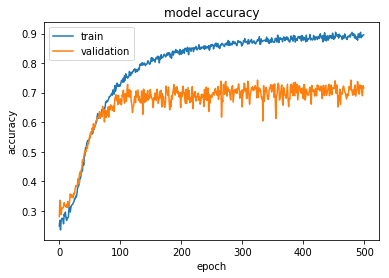

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

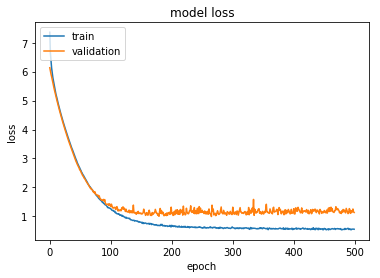

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

In [12]:
class_names = np.array(['left','right','foot','tongue'])
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true,y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(y_test, y_pred, classes=class_names,normalize=True,
                      title='Confusion matrix, with normalization')

NameError: name 'y_pred' is not defined

### The accuracy for each subject

In [108]:
data=np.zeros([9,1])
for i in range(9):
        data[i]=sum(y_pred[test_subject_idx[i]]==y_test[test_subject_idx[i]])/len(test_subject_idx[i])

column_name=['CNN++']
idx_name=['Subject_0', 'Subject_1','Subject_2','Subject_3','Subject_4','Subject_5','Subject_6','Subject_7','Subject_8']
df = pd.DataFrame(data=data,index=idx_name, columns=column_name)
df

,CNN++
Subject_0,0.680000
Subject_1,0.660000
Subject_2,0.780000
Subject_3,0.640000
Subject_4,0.808511
Subject_5,0.632653
Subject_6,0.860000
Subject_7,0.820000
Subject_8,0.787234
